In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import gc
from sklearn.preprocessing import RobustScaler

In [2]:
n_inds = 30
bayes_sample = 5000

fps = 30
scale = "07"
folders = ['0084', '0115', '0120']

angle_thresh = 30
time_thresh = 5
thresh_folder = 'angle' + str(angle_thresh) + '_time' + str(time_thresh)

In [3]:
for i,name in enumerate(folders):
    tmp = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/DirectionalCorrelation/Data/Output/golden_shiners/' + str(n_inds) + '_fish/' + name + '/' + thresh_folder + '/pairwise_' + scale + '.csv')
    tmp2 = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/DirectionalCorrelation/Data/Output/golden_shiners/' + str(n_inds) + '_fish/' + name + '/' + thresh_folder + '/individual_' + scale + '.csv')
    tmp['vid_id'] = i
    tmp2['vid_id'] = i
    
    pair_drops = ['Unnamed: 0', 'tau', 'ang_area']
    ind_drops = ['Unnamed: 0', 'rx', 'ry', 'lscore', 'lfinal', 'size']
    tmp.drop(pair_drops, axis=1, inplace=True)
    tmp2.drop(ind_drops, axis=1, inplace=True)
    
    if i != 0:
        pair1 = np.concatenate((pair1,tmp), axis=0)
        ind1 = np.concatenate((ind1,tmp2), axis=0)
    else:
        pair1 = tmp
        ind1 = tmp2
        cols = list(tmp)
        col_ind = list(tmp2)
        
pair1 = pd.DataFrame(pair1)
pair1.columns = cols

ind1 = pd.DataFrame(ind1)
ind1.columns = col_ind

In [4]:
n_inds = 10
folders = ['0066', '0105', '0126']

In [5]:
for i,name in enumerate(folders):
    tmp = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/DirectionalCorrelation/Data/Output/golden_shiners/' + str(n_inds) + '_fish/' + name + '/' + thresh_folder + '/pairwise_' + scale + '.csv')
    tmp2 = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/DirectionalCorrelation/Data/Output/golden_shiners/' + str(n_inds) + '_fish/' + name + '/' + thresh_folder + '/individual_' + scale + '.csv')
    tmp['vid_id'] = i+3
    tmp2['vid_id'] = i+3
    
    pair_drops = ['Unnamed: 0', 'tau', 'ang_area']
    ind_drops = ['Unnamed: 0', 'rx', 'ry', 'lscore', 'lfinal', 'size']
    tmp.drop(pair_drops, axis=1, inplace=True)
    tmp2.drop(ind_drops, axis=1, inplace=True)
    
    if i != 0:
        pair2 = np.concatenate((pair2,tmp), axis=0)
        ind2 = np.concatenate((ind2,tmp2), axis=0)
    else:
        pair2 = tmp
        ind2 = tmp2
        cols = list(tmp)
        col_ind = list(tmp2)
        
pair2 = pd.DataFrame(pair2)
pair2.columns = cols

ind2 = pd.DataFrame(ind2)
ind2.columns = col_ind

In [6]:
pairs = pd.concat([pair1,pair2], axis=0, sort=True)
inds = pd.concat([ind1,ind2], axis=0, sort=True)

In [7]:
del tmp
del tmp2
del pair1
del pair2
del ind1
del ind2

gc.collect()

64

In [8]:
df = pd.merge(pairs, inds)

del pairs
del inds

gc.collect()

0

In [9]:
df['cc'] = df['cc'].astype(np.int8)

df = df.dropna()

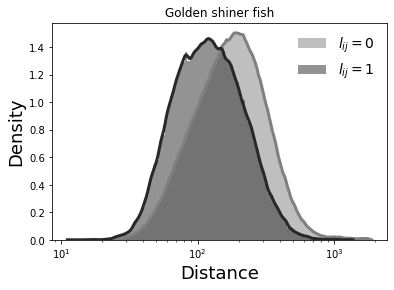

In [16]:
plt.rcParams['patch.linewidth'] = 0
sns.histplot(df.loc[df['cc'] == 0, 'dist'], label='$l_{ij}=0$', color='#808080', stat='density', log_scale=True, kde=True, line_kws={'linewidth': 3}, bins=100, common_bins=True)
sns.histplot(df.loc[df['cc'] == 1, 'dist'], label='$l_{ij}=1$', color='#282828', stat='density', log_scale=True, kde=True, line_kws={'linewidth': 3}, bins=100, common_bins=True)
plt.legend(loc=1, prop={'size' : 14}, frameon=False)#, bbox_to_anchor=(1.03, 1.4))
plt.title('Golden shiner fish')
plt.xlabel('Distance', fontsize=18)
plt.ylabel('Density', fontsize=18)

plt.savefig('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/DirectionalCorrelation/Figures/golden_shiners/angle30_time5/distances_fish.png', format='png', dpi=600, bbox_inches="tight")

In [ ]:
scaler = RobustScaler()
scaled = scaler.fit_transform(df[['ang_pos', 'dist', 'speed_diff', 'acc_diff', 'speed', 'acceleration']].values)

cols = ['ang_pos', 'dist', 'speed_diff', 'acc_diff', 'speed', 'acceleration']
df = df.drop(cols, axis=1)

for idx, col in enumerate(['ang_pos_scaled', 'dist_scaled', 'speed_diff_scaled', 'acc_diff_scaled', 'speed_scaled', 'acceleration_scaled']):
    df[col] = scaled[:, idx]
    
df.head()

### Run a bayesian model to predict leadership

In [11]:
bayes_df0 = df[df['cc'] == 0].sample(n = bayes_sample//2)
bayes_df1 = df[df['cc'] == 1].sample(n = bayes_sample//2)
bayes_df = pd.concat((bayes_df0, bayes_df1), axis=0)
bayes_df = bayes_df.sample(frac=1).reset_index(drop=True)

del bayes_df0
del bayes_df1

bayes_df['cc_rand'] = bayes_df['cc']
bayes_df['cc_rand'] = bayes_df['cc_rand'].sample(frac=1).values
bayes_df.head()

,cc,f_id,frame,n_id,vid_id,dev_gacc,dev_gspeed,ang_pos_scaled,dist_scaled,speed_diff_scaled,acc_diff_scaled,speed_scaled,acceleration_scaled,cc_rand
0,1,20.0,9429.0,4.0,2.0,0.013448,0.246425,0.216963,1.496682,-0.637132,-0.650798,-0.241786,-0.193643,1
1,0,13.0,14141.0,6.0,2.0,-0.002445,-0.467506,-0.761334,0.076821,0.274276,-0.054722,-0.759672,-0.374841,0
2,0,10.0,19509.0,3.0,2.0,-0.038098,-0.397912,0.410650,-0.036536,0.416911,0.382350,-0.517891,-0.576187,1
3,1,4.0,18297.0,1.0,2.0,-0.022535,-0.213092,-0.492582,-0.757542,0.529303,0.764536,-0.526057,-0.683644,1
4,1,8.0,22609.0,26.0,1.0,-0.008190,0.022335,0.115090,-0.525230,-0.374181,-0.158663,0.256264,-0.120239,1


In [12]:
# Save the dataframe
bayes_df.to_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/DirectionalCorrelation/Data/Output/golden_shiners/' + thresh_folder + '/bayes_df_s' + scale + '.csv', mode='w')

#### a) from a neural representation

In [13]:
mod = """
data {
    int<lower=0> n;
    int cc[n];
    real dist[n];
    real apos[n];
}
transformed data {}
parameters {
    real a;
    real b;
    real c;
}
transformed parameters {}
model {
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    c ~ normal(0, 10);
    
    for(i in 1:n) {
        cc[i] ~ bernoulli(inv_logit(a + b*dist[i] + c*apos[i]));
    }
}
generated quantities {
    int cc_pred[n];
    for(i in 1:n) {
        cc_pred[i] = bernoulli_rng(inv_logit(a + b*dist[i] + c*apos[i]));
    }
}
"""

data = {
        'n': len(bayes_df),
        'cc': bayes_df.cc,
        'dist': bayes_df.dist_scaled,
        'apos': bayes_df.ang_pos_scaled,
        }

neural_model = pystan.StanModel(model_code=mod, model_name='scale_' + scale)
# dd.io.save('Data/Output/golden_shiners/' + str(n_inds) + '_fish/nmod_s' + scale + '.h5', neural_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL scale_07_8252edb6095465b836890d0a76837b20 NOW.
In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:836:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948:
/Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:845:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Us

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:845:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Us

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:846:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_congruential_engine<unsigned l

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:845:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Us

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:845:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Us

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:845:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Us

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:845:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Us

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:845:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Us

161 warnings generated.
In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:836:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948:
/Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:845:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Us

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:845:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Us

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:846:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_congruential_engine<unsigned l

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:845:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Us

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:845:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Us

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:845:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Us

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:845:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Us

In file included from /var/folders/ng/l4j590g95vl5r33ctw59y6cr0000gn/T/pystan_a57kxulp/stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883.cpp:845:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/vivekhsridhar/Library/Python/3.8/lib/python/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/Us

160 warnings generated.


In [ ]:
neural_fit = neural_model.sampling(data=data, chains=4, iter=2000, control = dict(max_treedepth=15))
# dd.io.save('Data/Output/golden_shiners/' + str(n_inds) + '_fish/nfit_s' + scale + '.h5', neural_fit)

Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
ModuleNotFoundError: No module named 'stanfit4scale_07_8252edb6095465b836890d0a76837b20_7593529492940801883'
Process SpawnPoolWorker-4:
Traceback (most recent call last):
  File "/Library/Developer/Co

In [ ]:
acc_n = np.sum(neural_fit['cc_pred'] == np.array(bayes_df['cc']), axis=1) / len(bayes_df)
print(np.quantile(acc_n, 0.025), np.median(acc_n), np.quantile(acc_n, 0.975))

sns.distplot(acc_n, hist=True, kde=True, color = '#0799b9', kde_kws={'linewidth': 4})
plt.axvline(x=0.5, color='black', linestyle='dashed')

#### b) from kinematics

In [ ]:
mod = """
data {
    int<lower=0> n;
    int cc[n];
    real speed[n];
    real acc[n];
    real sdiff[n];
    real adiff[n];
}
transformed data {}
parameters {
    real a;
    real b;
    real c;
    real d;
    real e;
}
transformed parameters {}
model {
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    c ~ normal(0, 10);
    d ~ normal(0, 10);
    e ~ normal(0, 10);
    
    for(i in 1:n) {
        cc[i] ~ bernoulli(inv_logit(a + b*speed[i] + c*acc[i] + d*sdiff[i] + e*adiff[i]));
    }
}
generated quantities {
    int cc_pred[n];
    for(i in 1:n) {
        cc_pred[i] = bernoulli_rng(inv_logit(a + b*speed[i] + c*acc[i] + d*sdiff[i] + e*adiff[i]));
    }
}
"""

data = {
        'n': len(bayes_df),
        'cc': bayes_df.cc,
        'speed': bayes_df.speed_scaled,
        'acc': bayes_df.acceleration_scaled,
        'sdiff': bayes_df.speed_diff_scaled,
        'adiff': bayes_df.acc_diff_scaled,
        }

k_model = pystan.StanModel(model_code=mod, model_name='scale_' + scale)
# dd.io.save('Data/Output/golden_shiners/' + str(n_inds) + '_fish/kmod_s' + scale + '.h5', k_model)

In [ ]:
k_fit = k_model.sampling(data=data, chains=4, iter=2000, control = dict(max_treedepth=15))
# dd.io.save('Data/Output/golden_shiners/' + str(n_inds) + '_fish/kfit_s' + scale + '.h5', k_fit)

In [ ]:
acc_k = np.sum(k_fit['cc_pred'] == np.array(bayes_df['cc']), axis=1) / len(bayes_df)
print(np.quantile(acc_k, 0.025), np.median(acc_k), np.quantile(acc_k, 0.975))

sns.distplot(acc_k, hist=True, kde=True, color = '#ff0000', kde_kws={'linewidth': 4})
plt.axvline(x=0.5, color='black', linestyle='dashed')

#### c) from a neural representation + kinematics

In [ ]:
mod = """
data {
    int<lower=0> n;
    int cc[n];
    real dist[n];
    real apos[n];
    real speed[n];
    real acc[n];
    real sdiff[n];
    real adiff[n];
}
transformed data {}
parameters {
    real a;
    real b;
    real c;
    real d;
    real e;
    real f;
    real g;
}
transformed parameters {}
model {
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    c ~ normal(0, 10);
    d ~ normal(0, 10);
    e ~ normal(0, 10);
    f ~ normal(0, 10);
    g ~ normal(0, 10);
    
    for(i in 1:n) {
        cc[i] ~ bernoulli(inv_logit(a + b*dist[i] + c*apos[i] + d*speed[i] + e*acc[i] + f*sdiff[i] + g*adiff[i]));
    }
}
generated quantities {
    int cc_pred[n];
    for(i in 1:n) {
        cc_pred[i] = bernoulli_rng(inv_logit(a + b*dist[i] + c*apos[i]  + d*speed[i] + e*acc[i] + f*sdiff[i] + g*adiff[i]));
    }
}
"""

data = {
        'n': len(bayes_df),
        'cc': bayes_df.cc,
        'dist': bayes_df.dist_scaled,
        'apos': bayes_df.ang_pos_scaled,
        'speed': bayes_df.speed_scaled,
        'acc': bayes_df.acceleration_scaled,
        'sdiff': bayes_df.speed_diff_scaled,
        'adiff': bayes_df.acc_diff_scaled,
        }

nk_model = pystan.StanModel(model_code=mod, model_name='scale_' + scale)
# dd.io.save('Data/Output/golden_shiners/' + str(n_inds) + '_fish/nkmod_s' + scale + '.h5', nk_model)

In [ ]:
nk_fit = nk_model.sampling(data=data, chains=4, iter=2000, control = dict(max_treedepth=15))
# dd.io.save('Data/Output/golden_shiners/' + str(n_inds) + '_fish/nkfit_s' + scale + '.h5', nk_fit)

In [ ]:
acc_nk = np.sum(nk_fit['cc_pred'] == np.array(bayes_df['cc']), axis=1) / len(bayes_df)
print(np.quantile(acc_nk, 0.025), np.median(acc_nk), np.quantile(acc_nk, 0.975))

sns.distplot(acc_nk, hist=True, kde=True, color = '#800080', kde_kws={'linewidth': 4})
plt.axvline(x=0.5, color='black', linestyle='dashed')

### Accuracies over all models

In [ ]:
sns.distplot(acc_n, label='relative position (M1)', color='#0799b9', hist=True, kde=True, kde_kws={'linewidth': 1})
sns.distplot(acc_k, label='kinematics (M2)', color='#ff0000', hist=True, kde=True, kde_kws={'linewidth': 1})
sns.distplot(acc_nk, label='relative position and kinematics (M3)', color='#800080', hist=True, kde=True, kde_kws={'linewidth': 1})

plt.axvline(x=0.5, color='black', linestyle='dashed')
# plt.legend(loc=1, prop={'size' : 13}, edgecolor='black') # bbox_to_anchor=(1.03, 1.4)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0.48,0.80)
plt.yticks([0,20,40,60,80])
plt.ylim(0,90)
plt.savefig('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/DirectionalCorrelation/Figures/golden_shiners' + thresh_folder + '/accuracies_s' + scale + '_mod.png', format='png', dpi=600, bbox_inches="tight")